In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import yaml
from glob import glob
from torchvision import transforms

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

GradCAM model

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from inclearn.lib import factory
from inclearn.lib.network.classifiers import CosineClassifier, DynaCosineClassifier

class Model(nn.Module):
    def __init__(self, method, options, ckpt_path, add=None):
        super(Model, self).__init__()
        self.method = method
        self.convnet = factory.get_convnet(options['convnet'], **options['convnet_config']).to(torch.device('cuda'))
        if method == 'der' or method == 'ours':
            self.classifier = DynaCosineClassifier(self.convnet.out_dim, device=0, **options['classifier_config'])
        else:
            self.classifier = CosineClassifier(self.convnet.out_dim, device=0, **options['classifier_config'])
        
        self.classifier.add_classes(options['initial_increment'])
        if method == 'der' or method == 'ours':
            self.convnet.add_classes()

        if method != 'init':
            if add is None:
                add = int(ckpt_path.split('_')[-1].split('.')[0])
#                 add = (len(options['order'][0]) - options['initial_increment'])//options['increment']
            for _ in range(add):
                self.classifier.add_classes(options['increment'])
                if method == 'der' or method == 'ours':
                    self.convnet.add_classes()

        checkpoint = torch.load(ckpt_path)
        convnet_weights = {}
        classifier_weights = {}
        for n, p in checkpoint.items():
            if 'convnet' in n:
                convnet_weights[n.replace('convnet.','')] = p
            elif 'classifier' in n and 'aux' not in n:
                classifier_weights[n.replace('classifier.','')] = p

        self.convnet.load_state_dict(convnet_weights)
        self.classifier.load_state_dict(classifier_weights)

        self.gradients = None
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.convnet(x)

        if self.method == 'der' or self.method == 'ours':
            x = x['last_layer']
        else:
            x = x['attention'][-1]  
        
        # register the hook
        h = x.register_hook(self.activations_hook)

        x = self.pool(x)
        x = x.view(x.size(0), -1)        
        # apply the remaining pooling
        x = self.classifier(x)['logits']
        
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        if self.method == 'der' or self.method == 'ours':
            return self.convnet(x)['last_layer']         
        else:
            return self.convnet(x)['attention'][-1]  


/home/evelynyi/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


### EyePACS - Forgetting (Figure 5)

Paths to files corresponding to each method

**Instruction**: If using pretrained models, download them from https://drive.google.com/drive/folders/1aWwrF5K5KNPsvayQD4lXZaFdoLu6OS8O?usp=sharing and place them under the respective folders as indicated below. Otherwise, change the model paths to yours accordingly.

In [3]:
files = {
    'init': {
        'options': 'options/ucir/ucir_diabetic.yaml',
        'model': 'results/pretrain/ucir/20220403_ucir_diabetic_3steps1/net_0_task_0.pth'
    },
    'icarl': {
        'options': 'options/icarl/icarl_diabetic.yaml',
        'model': 'results/pretrain/icarl/20220403_icarl_diabetic_3steps1/net_0_task_2.pth'
    },
    'ucir': {
        'options': 'options/ucir/ucir_diabetic.yaml',
        'model': 'results/pretrain/ucir/20220403_ucir_diabetic_3steps1/net_0_task_2.pth'
    },
    'podnet': {
        'options': 'options/podnet/podnet_cnn_diabetic.yaml',
        'model': 'results/pretrain/podnet/20220403_podnet_cnn_diabetic_3steps1/net_0_task_2.pth'
    },
    'der': {
        'options': 'options/der/derE0_diabetic.yaml',
        'model': 'results/pretrain/der/20220404_derE0_diabetic_3steps1/net_0_task_2.pth'
    },
    'ours': {
        'options': 'options/der/derE3_diabetic.yaml',
        'model': 'results/pretrain/ours/20220403_derE3_diabetic_3steps1/net_0_task_2.pth'
    },

}

Load parameter settings and model 

**Instruction**: Change `method` accordingly to visualize the corresponding results

In [29]:
method = 'ours'

with open(files[method]['options']) as f:
    options = yaml.load(f, Loader=yaml.FullLoader)

with open('options/data/diabetic_3orders.yaml') as f:
    options.update(yaml.load(f, Loader=yaml.FullLoader))

options['device'] = '0'
options['initial_increment'] = 3
options['increment'] = 1
options['workers'] = 4 
options['batch_size'] = 64
options['random_classes'] = False
options['validation'] = 0
options['onehot'] = False
options['sampler'] = None
options['data_path'] = './data/diabetic/samples'

model = Model(method, options, files[method]['model'])

mean = [0.37376693, 0.37283142, 0.37173335]
std = [0.24538085, 0.24495832, 0.23954594]

transform = transforms.Compose([
    transforms.Resize((512, 512), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


Features dimension is 512.
Loading pretrained network


Load and visualize sample input image

**Instruction**: Change index in `path` to visualize the 3 different sample images

In [ ]:
paths = ['./data/diabetic/samples/7653_left_process.jpeg', './data/diabetic/samples/20719_left_process.jpeg']

path = paths[0]

input = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(torch.device('cuda'))
img = np.array(Image.open(path.replace('_process', '')))/255.
# display(Image.fromarray(np.uint8(np.clip(img,0,1)*255)))

model.eval()

# get the most likely prediction of the model
pred = model(input) #.argmax(dim=1)
print(pred.argmax(dim=1))
#     print(pred.shape)

# get the gradient of the output with respect to the parameters of the model
pred[:, pred.argmax(dim=1)].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(input).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()

img2 = np.uint8(np.clip(img,0,1)*255)
heatmap2 = cv2.resize(heatmap, (img2.shape[1], img2.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)[...,::-1]
superimposed_img = heatmap2 * 0.4 + img2
display(Image.fromarray(np.clip(superimposed_img, 0, 255).astype(np.uint8)))

### EyePACS - Learning (Figure 6a)

Load parameter settings and models at two different time step

**Instruction**: If using pretrained models, download them from https://drive.google.com/drive/folders/1aWwrF5K5KNPsvayQD4lXZaFdoLu6OS8O?usp=sharing and place them under the respective folders as indicated below. Otherwise, change the model paths to yours accordingly.

In [11]:
options_path = 'options/der/derE3_diabetic.yaml'
ckpt_path1 = 'results/pretrain/ours/20220403_derE3_diabetic_3steps1/net_1_task_1.pth'
ckpt_path2 = 'results/pretrain/ours/20220403_derE3_diabetic_3steps1/net_1_task_2.pth'

with open(options_path) as f:
    options = yaml.load(f, Loader=yaml.FullLoader)

with open('options/data/diabetic_3orders.yaml') as f:
    options.update(yaml.load(f, Loader=yaml.FullLoader))

options['device'] = '0'
options['initial_increment'] = 3 
options['increment'] = 1 
options['workers'] = 4 
options['batch_size'] = 64
options['random_classes'] = False
options['validation'] = 0
options['onehot'] = False
options['sampler'] = None
options['data_path'] = './data/diabetic/samples'

model1 = Model('ours', options, ckpt_path1, add=1)
model2 = Model('ours', options, ckpt_path2, add=2)

paths = glob(options['data_path']+'/*_process.jpeg')

mean = [0.37376693, 0.37283142, 0.37173335]
std = [0.24538085, 0.24495832, 0.23954594]

transform = transforms.Compose([
    transforms.Resize((512, 512), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


Features dimension is 512.
Loading pretrained network
Features dimension is 512.
Loading pretrained network


Load and visualize sample input image

**Instruction**: Change index in `path` to visualize the different sample images

tensor([1], device='cuda:0')


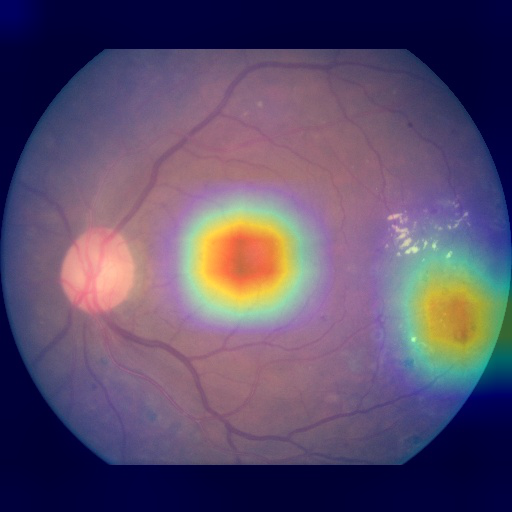

tensor([3], device='cuda:0')


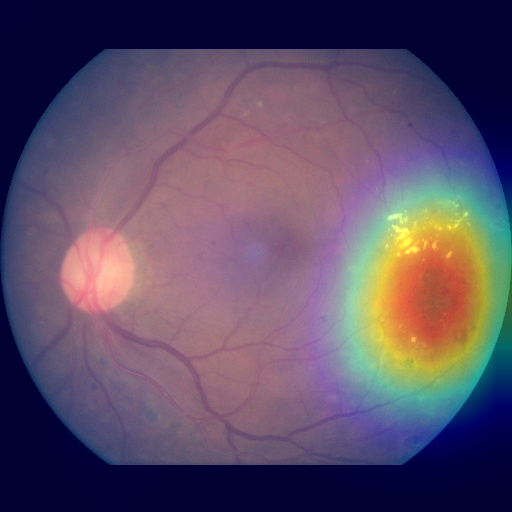

In [16]:
paths = ['./data/diabetic/samples/12682_right_process.jpeg', './data/diabetic/samples/4101_left_process.jpeg']

path = paths[0] # index=0/1

input = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(torch.device('cuda'))
img = np.array(Image.open(path.replace('_process','')))/255.
# display(Image.fromarray(np.uint8(np.clip(img,0,1)*255)))

for model in [model1, model2]:
    model.eval()

    # get the most likely prediction of the model
    pred = model(input) #.argmax(dim=1)
    print(pred.argmax(dim=1))

    # get the gradient of the output with respect to the parameters of the model
    pred[:, pred.argmax(dim=1)].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(input).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap.cpu(), 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()

    img2 = np.uint8(np.clip(img,0,1)*255)
    heatmap2 = cv2.resize(heatmap, (img2.shape[1], img2.shape[0]))
    heatmap2 = np.uint8(255 * heatmap2)
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)[...,::-1]
    superimposed_img = heatmap2 * 0.4 + img2
    display(Image.fromarray(np.clip(superimposed_img, 0, 255).astype(np.uint8)))

### HAM10000 - Learning (Figure 6b)

Load parameter settings and models at two different time step

**Instruction**: If using pretrained models, download them from https://drive.google.com/drive/folders/1aWwrF5K5KNPsvayQD4lXZaFdoLu6OS8O?usp=sharing and place them under the respective folders as indicated below. Otherwise, change the model paths to yours accordingly.

In [19]:
options_path = 'options/der/derE3_ham10000.yaml'
ckpt_path1 = 'results/pretrain/ours/20220406_derE3_ham10000_3steps1/net_0_task_2.pth'
ckpt_path2 = 'results/pretrain/ours/20220406_derE3_ham10000_3steps1/net_0_task_4.pth'

with open(options_path) as f:
    options = yaml.load(f, Loader=yaml.FullLoader)

with open('options/data/ham10000_3orders.yaml') as f:
    options.update(yaml.load(f, Loader=yaml.FullLoader))

options['device'] = '0'
options['initial_increment'] = 3
options['increment'] = 1 
options['workers'] = 4 
options['batch_size'] = 64
options['random_classes'] = False
options['validation'] = 0
options['onehot'] = False
options['sampler'] = None
options['data_path'] = './data/ham10000/samples'

model1 = Model('ours', options, ckpt_path1)
model2 = Model('ours', options, ckpt_path2)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((256, 256), Image.BILINEAR),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


Features dimension is 512.
Loading pretrained network
Features dimension is 512.
Loading pretrained network


tensor([2], device='cuda:0')


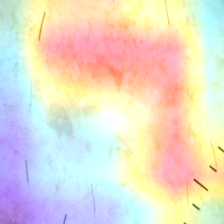

tensor([4], device='cuda:0')


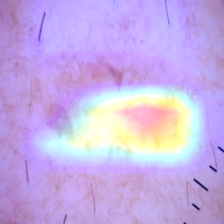

In [22]:
paths = glob(options['data_path']+'/*.jpg')

path = paths[1] # index=0/1

input = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(torch.device('cuda'))
img = (input[0].cpu().numpy()*np.array(std).reshape(3,1,1)+np.array(mean).reshape(3,1,1)).transpose(1,2,0)
# display(Image.fromarray(np.uint8(np.clip(img,0,1)*255)))

for model in [model1, model2]:
    model.eval()

    # get the most likely prediction of the model
    pred = model(input) #.argmax(dim=1)
    print(pred.argmax(dim=1))

    # get the gradient of the output with respect to the parameters of the model
    pred[:, pred.argmax(dim=1)].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(input).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap.cpu(), 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()

    img2 = np.uint8(np.clip(img,0,1)*255)
    heatmap2 = cv2.resize(heatmap, (img2.shape[1], img2.shape[0]))
    heatmap2 = np.uint8(255 * heatmap2)
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)[...,::-1]
    superimposed_img = heatmap2 * 0.4 + img2
    display(Image.fromarray(np.clip(superimposed_img, 0, 255).astype(np.uint8)))